In [1]:
# %load "../scripts/utils.py"
#!/usr/bin/env python
""" Utility functions used throughout the analysis."""
import utils
import re
import numpy as np
import xarray as xr
import faceted as faceted
import pandas as pd
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.colors as mcolors

def get_path(path):
    absolute_path = "/home/tarshish/Documents/research/zec/"
    return absolute_path + path 

/home/tarshish/micromamba/envs/zec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.set_plot_configs(plt, fsize=8)

In [3]:
results_dir = utils.get_path('results')

In [4]:
def gen_fair_CO2_only(scenarios, run_type, years=[0,100]):
    ensemble_members = 841
    prefix = get_path("datasets/fair_calibrate")
    fair_v = "2.1.3"
    cal_v = "1.4"
    constraint_set = "all-2022"

    posterior_dir = prefix+f"/output/fair-{fair_v}/v{cal_v}/{constraint_set}/posteriors/"
    calibrated_params = posterior_dir+"calibrated_constrained_parameters.csv"
    calibration_dir = prefix+f"/output/fair-{fair_v}/v{cal_v}/{constraint_set}/calibrations/"
    df_configs = pd.read_csv(calibrated_params, index_col=0)
    df_configs_subset = df_configs[:ensemble_members]
    valid_all = df_configs_subset.index

    f = FAIR(ch4_method="leach2021")
    f.define_time(years[0], years[1], 1)
    f.define_scenarios(scenarios)
    f.define_configs(valid_all)

    species = ["CO2","CH4","N2O"]
    props = {"CO2": {'type': "co2",'input_mode': run_type,
                     'greenhouse_gas': True,
                     'aerosol_chemistry_from_emissions': False,
                     'aerosol_chemistry_from_concentration': False}}
    
    for gas in ["CH4","N2O"]:
        props[gas] = {'type': gas.lower(),'input_mode': 'concentration',
                      'greenhouse_gas': True,
                      'aerosol_chemistry_from_emissions': False,
                      'aerosol_chemistry_from_concentration': False}
        
    f.define_species(species, props)
    f.allocate()
    f.fill_species_configs()

    fill(f.climate_configs["ocean_heat_capacity"], df_configs_subset.loc[:, "clim_c1":"clim_c3"].values)
    fill(f.climate_configs["ocean_heat_transfer"], df_configs_subset.loc[:, "clim_kappa1":"clim_kappa3"].values)
    fill(f.climate_configs["deep_ocean_efficacy"], df_configs_subset["clim_epsilon"].values.squeeze())
    fill(f.climate_configs["gamma_autocorrelation"], df_configs_subset["clim_gamma"].values.squeeze())
    fill(f.climate_configs["sigma_eta"], df_configs_subset["clim_sigma_eta"].values.squeeze())
    fill(f.climate_configs["sigma_xi"], df_configs_subset["clim_sigma_xi"].values.squeeze())
    fill(f.climate_configs["seed"], df_configs_subset["seed"])
    fill(f.climate_configs["stochastic_run"], False)
    fill(f.climate_configs["use_seed"], False)
    fill(f.climate_configs["forcing_4co2"], df_configs_subset["clim_F_4xCO2"])

    fill(f.species_configs["iirf_0"], df_configs_subset["cc_r0"].values.squeeze(), specie="CO2")
    fill(f.species_configs["iirf_airborne"], df_configs_subset["cc_rA"].values.squeeze(), specie="CO2")
    fill(f.species_configs["iirf_uptake"], df_configs_subset["cc_rU"].values.squeeze(), specie="CO2")
    fill(f.species_configs["iirf_temperature"], df_configs_subset["cc_rT"].values.squeeze(), specie="CO2")

    fill(f.species_configs["forcing_scale"], df_configs_subset["fscale_CO2"].values.squeeze(), specie="CO2")
    fill(f.species_configs["baseline_concentration"], df_configs_subset["cc_co2_concentration_1750"].values.squeeze(), specie="CO2")

    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)

    fill(f.concentration, f.species_configs["baseline_concentration"].sel(specie="CH4"), specie="CH4")
    fill(f.concentration, f.species_configs["baseline_concentration"].sel(specie="N2O"), specie="N2O")

    return f

In [5]:
f = gen_fair_CO2_only(["1pct_CO2"], "concentration")

In [6]:
CO2_1pct_per_yr = f.species_configs["baseline_concentration"].sel(specie="CO2")*(1.01)**(f.concentration.timebounds)
fill(f.concentration, CO2_1pct_per_yr, specie="CO2")

In [7]:
f.run()

Running 841 projections in parallel: 100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 2024.66timesteps/s]


In [8]:
cumulative_emissions = f.cumulative_emissions.interp(timebounds=f.emissions.timepoints)

In [9]:
active_emissions = f.emissions.where(cumulative_emissions < 1000*44/12, other=0)

In [10]:
g = gen_fair_CO2_only(["1pct_CO2"], "emissions", years=[0,1000])
fill(g.concentration, g.species_configs["baseline_concentration"].sel(specie="CO2"), specie="CO2")

In [11]:
fill(g.emissions, 0)

In [12]:
g.emissions[:100, ...] = active_emissions

In [13]:
g.run()

Running 841 projections in parallel: 100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 2043.58timesteps/s]


In [14]:
color=sns.color_palette("tab10")[0]

In [15]:
lines = g.temperature.isel(scenario=0, layer=0).load()

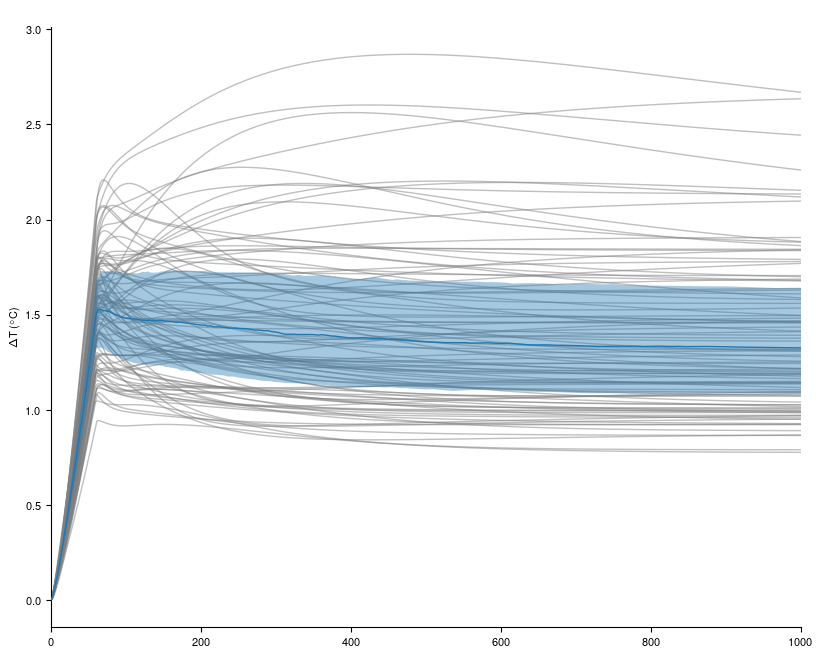

In [16]:
fig, (axis,) = faceted.faceted(1,1, aspect=.8)
y = g.temperature.isel(scenario=0, layer=0).values
x = g.timebounds
lines.isel(config=slice(0,100)).plot.line(x="timebounds", color="grey", alpha=.5, add_legend=False, zorder=0, linewidth=1)
utils.plot_median(x,y, spread=[25,75], axis = axis, color=sns.color_palette("tab10")[0])
sns.despine()
axis.set_ylabel(r"$\Delta$T (${}^\circ$C)")
axis.set_title(" ")
axis.set_xlabel(" ")
axis.set_xlim([0,1000])
fig.savefig(results_dir+"/figures/1pct_ensemble.pdf", bbox_inches="tight")

In [17]:
emissions = g.emissions.sel(specie="CO2").isel(scenario=0)
temp = g.temperature.isel(layer=0, scenario=0)
pos_emissions_mask = (emissions > 0)
valid_times = pos_emissions_mask * emissions.coords['timepoints']  # This assumes timepoints are numeric
last_positive_emissions_time = valid_times.max(dim='timepoints')   # Dimension: config
# # Step 2: Select temperature at that time. Assuming temperature at timebounds=t+1 corresponds to the interval end
# last_temp = temp.isel(timebounds=last_positive_time + 1)

In [18]:
Tze = temp.sel(timebounds=last_positive_emissions_time+.5)
Tf = temp.isel(timebounds=-1)

In [19]:
ZEC_div_Tze = (Tf - Tze)/Tze

In [20]:
kde = stats.gaussian_kde(ZEC_div_Tze.values, bw_method="silverman")

In [21]:
sample_range = np.linspace(-1, 1, 1000)
# Compute KDE for the current scenario
kde = stats.gaussian_kde(ZEC_div_Tze.values, bw_method="silverman")
kde_data = kde.evaluate(sample_range)

In [22]:
ecdf = stats.ecdf(ZEC_div_Tze).cdf
pos_ZEC_percent = (1-ecdf.evaluate(0))*100
pos_ZEC_percent = int(np.round(pos_ZEC_percent,decimals=0))

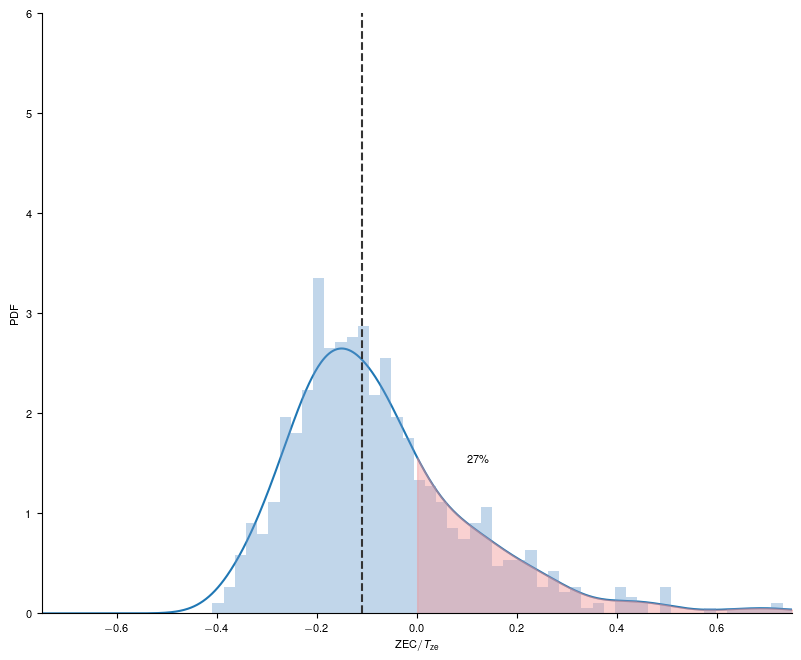

In [23]:
# Set up the figure and subplots with swapped widths
fig, (axis,) = faceted.faceted(1,1, aspect=.8)

axis.plot(sample_range, kde_data)
axis.set_xlim([-.75, .75])
axis.set_ylim([0, 6])
axis.set_xlabel(r"$\text{ZEC}/T_\text{ze}$")
axis.set_ylabel(r"PDF")
axis.spines['right'].set_visible(False)
axis.spines['top'].set_visible(False)

axis.hist(
    ZEC_div_Tze, density=True, bins=60, alpha=0.4,
    color="#6699cc", edgecolor="none", zorder=2
)
axis.fill_between(
    sample_range[sample_range > 0], 0, kde_data[sample_range > 0],
    color='#f28e8e', zorder=2, alpha=0.4
)
quantile_16 = np.quantile(ZEC_div_Tze, 0.16)
quantile_84 = np.quantile(ZEC_div_Tze, 0.84)
interquantile = (sample_range > quantile_16) & (sample_range < quantile_84)
axis.fill_between(
    kde_data[interquantile], 0, kde_data[interquantile],
    color='#b0b0b0', zorder=2, alpha=0.6
)
median = np.quantile(ZEC_div_Tze, 0.5)
axis.axvline(
    median, ymin=0,
    ymax=kde.pdf(median)[0],
    color='#333333', linewidth=1.5, zorder=3, linestyle="dashed"
)
axis.text(0.1, 1.5, f"${pos_ZEC_percent}\%$", color="black", zorder=4)

fig.savefig(results_dir+"/figures/co2_only_1pct.pdf", bbox_inches="tight")

In [24]:
da_emissions = xr.load_dataarray(utils.get_path("results/emissions.nc"))     
ssp_CO2_emissions = da_emissions.sel(specie=["CO2 FFI", "CO2 AFOLU"]).sum("specie")

results = []

for scenario in ["ssp119","ssp126","ssp534-over","historical"]:
    
    h = gen_fair_CO2_only([scenario], "emissions", years = [1750,3000])
    
    fill(h.emissions, 0)
    h.emissions[:750, ..., 0] = ssp_CO2_emissions.sel(scenario=scenario).drop("config")
    
    utils.ZEC_emissions(h, year = utils.get_net_zero_CO2_time(h.scenarios[0]))
    h.run()
    results.append(h.temperature)

/tmp/ipykernel_75054/899957367.py:11: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  h.emissions[:750, ..., 0] = ssp_CO2_emissions.sel(scenario=scenario).drop("config")
Running 841 projections in parallel: 100%|█████████████████████████████████████████| 1250/1250 [00:01<00:00, 943.02timesteps/s]
/tmp/ipykernel_75054/899957367.py:11: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  h.emissions[:750, ..., 0] = ssp_CO2_emissions.sel(scenario=scenario).drop("config")
Running 841 projections in parallel: 100%|█████████████████████████████████████████| 1250/1250 [00:01<00:00, 946.48timesteps/s]
/tmp/ipykernel_75054/899957367.py:11: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  h.emissions[:750, ..., 0] = ssp_CO2_emissions.sel(scenario=scenario).drop("config")
Running 841 projections in parallel: 100%|████████████████████████████████████████| 1250/1250 [00:00<00:00, 1658.49timesteps/s

In [25]:
temp = xr.concat(results, dim="scenario")
temp.name = "temperature"
ds = temp.to_dataset()

In [26]:
sample_range = np.linspace(-1, 1, 1000)

kde_results = {}

ZEC_div_Tze_results = []

# Iterate over each scenario
for scenario in ds.scenario:

    Tze = ds.temperature.sel(timebounds=utils.get_net_zero_CO2_time(scenario.item())-.5,
                             scenario=scenario).isel(layer=0)
    Tf = ds.temperature.sel(timebounds=3000, scenario=scenario).isel(layer=0)
    ZEC_div_Tze = (Tf - Tze)/Tze
    
    # Compute KDE for the current scenario
    kde = stats.gaussian_kde(ZEC_div_Tze.values, bw_method="silverman")
    
    # Evaluate the KDE on the sample range
    kde_data = kde.evaluate(sample_range)
    
    # Store the result in the dictionary (or another xarray if preferred)
    kde_results[scenario.values.item()] = kde_data
    ZEC_div_Tze_results.append(ZEC_div_Tze.drop_vars("timebounds"))
    
kde_xarray = xr.DataArray(
    np.array(list(kde_results.values())), 
    coords=[list(kde_results.keys()), sample_range], 
    dims=["scenario", "sample_range"]
)

ZEC_div_Tze = xr.concat(ZEC_div_Tze_results, dim="scenario")

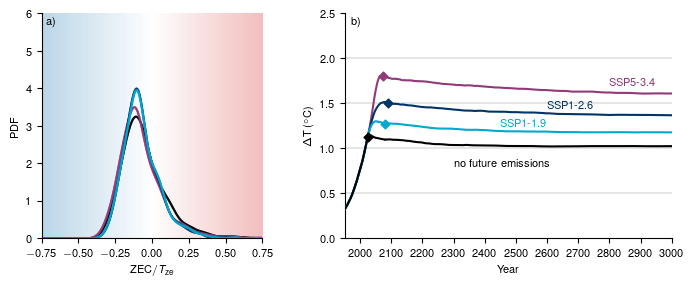

In [27]:
median = ds.temperature.isel(layer=0).quantile(.5, dim='config').compute()

# Define your figure and axis sizes
figheight = 3
figwidth = 7
hspace = .1
wspace = .2

markersize = 20
markershape = "D"
linewidth=1.5

# Set up the figure and subplots with swapped widths
fig = plt.figure(figsize=(figwidth, figheight))
gs = fig.add_gridspec(1, 2, width_ratios=(1.35, 2), wspace=.3)
ax0 = fig.add_subplot(gs[0])  
ax1 = fig.add_subplot(gs[1])  

fig.subplots_adjust(left=.05, right=.95, top=.9, bottom=.15) 

# Right-hand plot (now ax0): KDE plot
for scenario in kde_xarray.scenario[::-1]:
    ax0.plot(sample_range, kde_xarray.sel(scenario=scenario), color=utils.get_color(scenario.item()),
             linewidth=linewidth, alpha=.8)

    ax0.plot(sample_range, kde_xarray.sel(scenario=scenario), color=utils.get_color(scenario.item()),
             linewidth=linewidth, alpha=.8)
    
ax0.set_xlim([-.75, .75])
ax0.set_ylim([0, 6])
ax0.set_xlabel(r"$\text{ZEC}/T_\text{ze}$")
ax0.set_ylabel(r"PDF")
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

# color gradient 
gradient = np.linspace(-0.75, 0.25, 100)  # X-axis gradient
gradient = np.tile(gradient, (100, 1))  # Create a 2D gradient for background
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#1f77b4", "white", "#d62728"])
ax0.imshow(gradient, aspect='auto', extent=[-0.75, 0.75, 0, 6], origin='lower', cmap=cmap, alpha=0.3)


# Left-hand plot (now ax1): time and temperature anomaly
for scenario in ds.sel(scenario=['ssp534-over', 'ssp126', 'ssp119', 'historical']).scenario:
    d = ds.sel(scenario=scenario)
    ax1.plot(d.timebounds, median.sel(scenario=scenario), color=utils.get_color(scenario.item()), zorder=3,
             linewidth=linewidth, label=utils.get_title(scenario.item()))
    
    # Scatter points for net-zero times and final temperatures
    net_zero_time = utils.get_net_zero_GHG_time(scenario.item()) - 0.5 
    ax1.scatter(net_zero_time,
                median.sel(scenario=scenario, timebounds=net_zero_time),
                zorder=5, color=utils.get_color(scenario.item()), marker=markershape, s=markersize)

    
    # print(f"Total cooling after peak for {scenario.item()} is "
    #       f"{-np.round((T_net_zero - Tfinal).sel(scenario=scenario).values, 2)} K")


ax1.set_ylim([0, 2.5])
ax1.set_xlim([1950, 3000])
ax1.set_ylabel(r"$\Delta$T (${}^\circ$C)")
ax1.set_xlabel(r"Year")
ax1.set_xticks(np.arange(2000, 3100, 100))  # Simplified x-ticks for clarity
# ax1.axvline(2100, ymax=2.5, linestyle='dashed', color='grey')

ax1.text(2300, .8, "no future emissions", color=utils.get_color("historical"))
ax1.text(2800, 1.7, "SSP5-3.4", color=utils.get_color("ssp534-over"))
ax1.text(2600, 1.45, "SSP1-2.6", color=utils.get_color("ssp126"))
ax1.text(2450, 1.25, "SSP1-1.9", color=utils.get_color("ssp119"))

for ydata in [.5,1,1.5,2]:
    ax1.axhline(ydata, linestyle='solid', alpha=0.6, color="black", linewidth=.25)
    
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

for ax, label in zip([ax0,ax1], ["a)", "b)"]):
    ax.text(0.02,0.96,label,transform=ax.transAxes,horizontalalignment="left",verticalalignment="center")

# # Save and show the figure
fig.savefig(results_dir+"/figures/co2_only_fig_3.pdf")
plt.show()

In [28]:
for scenario in ZEC_div_Tze.scenario:
    d = ZEC_div_Tze.sel(scenario=scenario)

    median = d.quantile(0.5, dim="config")
    lower_bound = d.quantile(0.25, dim="config")
    upper_bound = d.quantile(0.75, dim="config")
    
    print(f"Scenario: {scenario}")
    print(f"Median: {median.values:.2f}")
    print(f"5-95% Confidence Bounds: ({lower_bound.values:.2f}, {upper_bound.values:.2f})\n")

Scenario: <xarray.DataArray 'scenario' ()>
array('ssp119', dtype='<U11')
Coordinates:
    scenario  <U11 'ssp119'
    layer     int64 0
Median: -0.09
5-95% Confidence Bounds: (-0.15, -0.00)

Scenario: <xarray.DataArray 'scenario' ()>
array('ssp126', dtype='<U11')
Coordinates:
    scenario  <U11 'ssp126'
    layer     int64 0
Median: -0.09
5-95% Confidence Bounds: (-0.15, -0.00)

Scenario: <xarray.DataArray 'scenario' ()>
array('ssp534-over', dtype='<U11')
Coordinates:
    scenario  <U11 'ssp534-over'
    layer     int64 0
Median: -0.10
5-95% Confidence Bounds: (-0.17, -0.01)

Scenario: <xarray.DataArray 'scenario' ()>
array('historical', dtype='<U11')
Coordinates:
    scenario  <U11 'historical'
    layer     int64 0
Median: -0.08
5-95% Confidence Bounds: (-0.15, 0.02)

